In [1]:
#%pip install unidecode

In [2]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from unidecode import unidecode

#### Prepare for Dataset

In [3]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = unidecode(open('./sherlock.txt').read())
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 3381982
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [4]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 256  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [5]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [6]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 150       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.rnn = nn.RNNCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.rnn(input, hidden)
        output = self.linear(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): RNNCell(100, 150)
  (linear): Linear(in_features=150, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [7]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [8]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [9]:
# Number of iterations.
# NOTE: You may reduce the number of training iterations if the training takes long.
iters       = 20000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.002)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss.item()                             # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/20000 loss:3.078964288234711
generated sequence: W(ietp  arer nWtii..ohtt  .nuchc? dyvrah tIwerctwi
oas rrt i ah    amteec .d tem oseotot  nkn o hNhen

iter:199/20000 loss:2.7963463115692138
generated sequence: Wiyo narghulces u aon wicushbosilnga.tohe hhtl  tyocrf fmunuls .irryocecittee a-fhe   ylnarwe t  hhet

iter:299/20000 loss:2.4918797612190247
generated sequence: Wce?

    y ued wotile Isouwerotd-Thenile mimen'lant thap.ant somattet fmad, ame mopu!jaly . ?ust"rhe

iter:399/20000 loss:2.3214094638824463
generated sequence: W-"whee drerkighvepiwhlre aocpes angatd the ced waplo tho  h cho koutwin wost nt aug metwan!lcweokn N

iter:499/20000 loss:2.221277060508728
generated sequence: Wax)qtics ind Abqmerall, tomenk eor cee, Saln.

      "remamwengrede ftomeny Domenk s'ont we clenle. 

iter:599/20000 loss:2.237410236597061
generated sequence: W
 T   Acksacotseningod, awas ot af thicho, B
     ?"AA you michiws

     fery er hey wurkeind su ine

iter:699/20000 loss:2.1154255712

iter:5199/20000 loss:1.618125925064087
generated sequence: Well, en casceused is a have you receec, him. I offace, fourteivind the coning the ather in my owanin

iter:5299/20000 loss:1.649488558769226
generated sequence: Wit who I mest had
     they litt yinay dagger go. He seikhown what staression. It wall! As insomithe

iter:5399/20000 loss:1.6213734173774719
generated sequence: Was and
     rerooble still ham
     dirzinted. "Why matwe from you suct
     fruadled time that
    

iter:5499/20000 loss:1.6095736992359162
generated sequence: Watins to fe and lape."

     "No?"

     "The
     molker."

     "Now, of EItrige. OA relemed of th

iter:5599/20000 loss:1.6355764806270598
generated sequence: We lisely biguraswore before a ficht is more. Of a mandery bs ope your from no hew "'Top companisard 

iter:5699/20000 loss:1.6223457908630372
generated sequence: We strangerdessat to Ehumprie, some makever."

     "Whetention to when was
     gral whother it. Qum

iter:5799/20000 loss:1.6

iter:10299/20000 loss:1.5253965151309967
generated sequence: Wals as the some for Stants the worn. There would be ghe, brokand down om
     hele. A chimplet and r

iter:10399/20000 loss:1.5430208599567414
generated sequence: Were, Mr. So it. Whe theconcless betwey From
     non
     appablers
     a
     deay of the hous! an

iter:10499/20000 loss:1.5450627946853637
generated sequence: Well?"

     "Wy
     wall. Laster, weight spotel banger adeligh had hapse, last nom.

     "Well to 

iter:10599/20000 loss:1.5184241700172425
generated sequence: Which window hat aund, wallouss? In the walked the round like you any consectroors. "My take, Witson'

iter:10699/20000 loss:1.5304275965690612
generated sequence: Whno to fath out in it wem, but it was aswortious--the readd high ax the PaPer a heme room. He had a 

iter:10799/20000 loss:1.5361183261871338
generated sequence: Whte that
     were, sittench which to phint of like any goin happen who hungon this worlows. He.
   

iter:10899/20000

iter:15399/20000 loss:1.4817226314544678
generated sequence: We stypottang in hisheding in me instrects.
     "That, and he dimssiers, intstain down the drouble g

iter:15499/20000 loss:1.4874404239654542
generated sequence: Was spon
     you see is ieman with a the morny crese what
     I was from just I groon the goon from

iter:15599/20000 loss:1.4999211418628693
generated sequence: Wels."

     "Sir, the aways am such they last might business to puphie in, has cassable in eyes in t

iter:15699/20000 loss:1.5083181428909302
generated sequence: We this appectled. Ahsure to shoous, I see fol--hearhturlly
     a Solenn freized?"

     "Anytlis li

iter:15799/20000 loss:1.4849495637416839
generated sequence: Weaved. Aliay of evenion, we sholmate howells upon the queroush. Mervil thinkened that this find me, 

iter:15899/20000 loss:1.5344503688812257
generated sequence: Will us wh her thir Wandible doal you a she
     do at the nemeror unexman, liect," said she
     mor

iter:15999/20000

#### Training Loss Curve

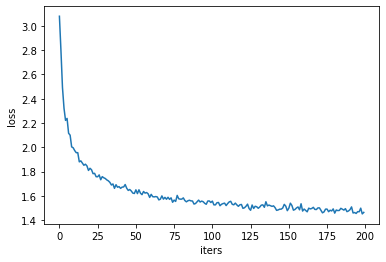

In [10]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [11]:
print(eval_step(net, predicted_len=600))

Why sonerd and agearse ahar linich hour, but we here
     we had no liked."

     "Yes, with his bringat.

     "I have his dolshats. You were no would oeper. Then it my of heog calling of a can on in
     the stage as no doam, dhid, sofing to his kecentted, and given the Treepland, back had seen, and I get an his
     an in port, which a caken. This fect
     chet, no
     cleach down the nood-good at
     above the edwed," inthing of his slep open as to
     aguating sum! He was prusure.

     "Anloweraal worked on if he eine listanic, and they cart of mone, she lilfsy then? It oerers quier d
